In [ ]:
!pip install tensorflow pandas numpy skleran matplotlib

ERROR: Could not find a version that satisfies the requirement skleran (from versions: none)
ERROR: No matching distribution found for skleran


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7575 - loss: 0.5136 - val_accuracy: 0.9423 - val_loss: 0.2296
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9388 - loss: 0.2611 - val_accuracy: 0.9423 - val_loss: 0.2270
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9408 - loss: 0.2566 - val_accuracy: 0.9423 - val_loss: 0.2247
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9407 - loss: 0.2510 - val_accuracy: 0.9423 - val_loss: 0.2248
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.2632 - val_accuracy: 0.9423 - val_loss: 0.2222
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9454 - loss: 0.2318 - val_accuracy: 0.9423 - val_loss: 0.2261
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9389 - loss: 0.2454 - val_accuracy: 0.9423 - val_loss: 0.2227
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9388 - loss: 0.2483 - val_accuracy: 

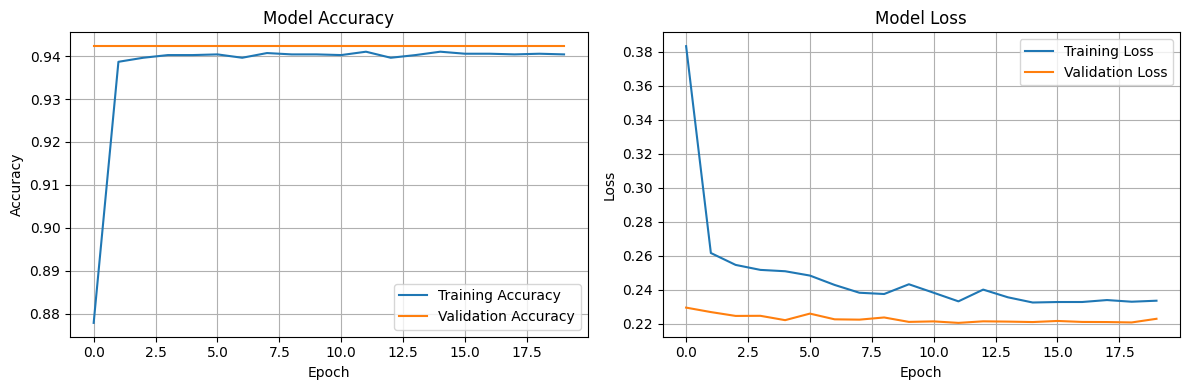

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step

Prediction for new instance:
Class: Fraud
Confidence: 76.74%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = "Final_1.csv"
data = pd.read_csv(file_path)

# Select attributes
attributes = [
    "Account_Age(months)",
    "Frequency_credential_change(per year)",
    "Return_to_Order",
    "VPN/Temp_Mail?",
    "Credit Score"
]

# Preprocess the data
if "VPN/Temp_Mail?" in data.columns:
    data["VPN/Temp_Mail?"] = data["VPN/Temp_Mail?"].map({"Yes": 1, "No": 0})
if "Fraud/NOT" in data.columns:
    data["Fraud/NOT"] = data["Fraud/NOT"].map({"Yes": 1, "No": 0})

# Drop rows with missing values
data = data.dropna(subset=attributes + ["Fraud/NOT"])

# Split features and target
X = data[attributes]
y = data["Fraud/NOT"]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network
def create_model(input_dim):
    model = models.Sequential([
        # Input layer
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.3),

        # Hidden layer 1
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        # Hidden layer 2
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),

        # Hidden layer 3
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create and compile the model
model = create_model(X_train.shape[1])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Function to plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Function to predict new instances
def predict_instance(model, scaler, new_instance):
    # Scale the new instance
    new_instance_scaled = scaler.transform([new_instance])

    # Make prediction
    prediction = model.predict(new_instance_scaled)[0][0]

    # Get class and probability
    predicted_class = "Fraud" if prediction >= 0.5 else "Not Fraud"
    probability = prediction if prediction >= 0.5 else 1 - prediction

    return predicted_class, probability

# Plot training history
plot_training_history(history)

# Example usage for new instance
new_instance = [3, 6, 1, 0, 650]  # Replace with your values
predicted_class, probability = predict_instance(model, scaler, new_instance)
print(f"\nPrediction for new instance:")
print(f"Class: {predicted_class}")
print(f"Confidence: {probability:.2%}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


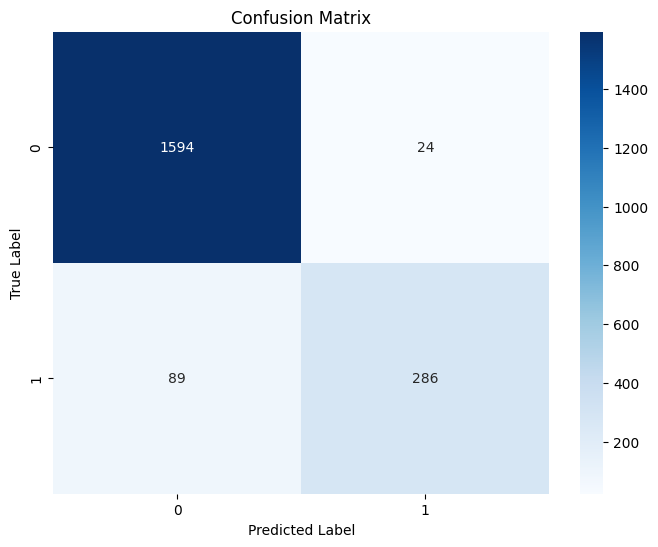


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1618
           1       0.92      0.76      0.84       375

    accuracy                           0.94      1993
   macro avg       0.93      0.87      0.90      1993
weighted avg       0.94      0.94      0.94      1993


Detailed Metrics:
True Negatives: 1594
False Positives: 24
False Negatives: 89
True Positives: 286

Precision: 0.9226
Recall: 0.7627
F1 Score: 0.8350


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# [Previous code remains the same until model evaluation]

# Get predictions for test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nDetailed Metrics:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

In [ ]:
new_instance = [36, 6, 0.5, 0, 650]  # Replace with your values
predicted_class, probability = predict_instance(model, scaler, new_instance)
print(f"\nPrediction for new instance:")
print(f"Class: {predicted_class}")
print(f"Confidence: {probability:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Prediction for new instance:
Class: Not Fraud
Confidence: 91.09%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
new_instance = [3, 6, .2, 1, 250]  # Replace with your values
predicted_class, probability = predict_instance(model, scaler, new_instance)
print(f"\nPrediction for new instance:")
print(f"Class: {predicted_class}")
print(f"Confidence: {probability:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Prediction for new instance:
Class: Not Fraud
Confidence: 85.22%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
new_instance = [56, 8, .6, 0, 250]  # Replace with your values
predicted_class, probability = predict_instance(model, scaler, new_instance)
print(f"\nPrediction for new instance:")
print(f"Class: {predicted_class}")
print(f"Confidence: {probability:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Prediction for new instance:
Class: Fraud
Confidence: 65.98%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import joblib
from google.colab import files

# 1. Save the model (using .keras extension as recommended)
model.save('fraud_detection_model.keras')

# 2. Save the scaler
joblib.dump(scaler, 'scaler.save')

# 3. Zip the files
!zip -r model_files.zip fraud_detection_model.keras scaler.save

# 4. Download the zip file
files.download('model_files.zip')


  adding: fraud_detection_model.keras (deflated 49%)
  adding: scaler.save (deflated 30%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1618
           1       0.92      0.76      0.83       375

    accuracy                           0.94      1993
   macro avg       0.93      0.87      0.90      1993
weighted avg       0.94      0.94      0.94      1993



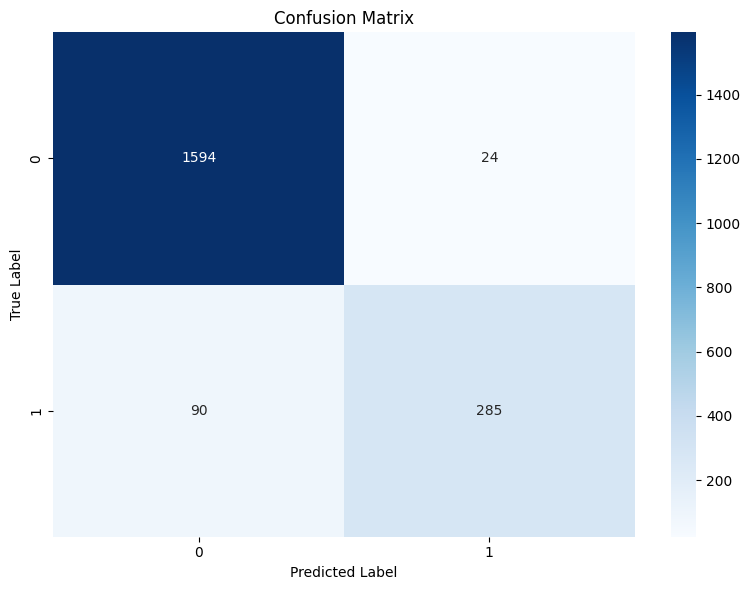


Prediction for new instance:
Predicted Class: Fraud
Probability of Not Fraud: 25.00%
Probability of Fraud: 75.00%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


['rf_scaler.joblib']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
file_path = "Final_1.csv"
data = pd.read_csv(file_path)

# Select attributes
attributes = [
    "Account_Age(months)",
    "Frequency_credential_change(per year)",
    "Return_to_Order",
    "VPN/Temp_Mail?",
    "Credit Score"
]

# Preprocess the data
if "VPN/Temp_Mail?" in data.columns:
    data["VPN/Temp_Mail?"] = data["VPN/Temp_Mail?"].map({"Yes": 1, "No": 0})
if "Fraud/NOT" in data.columns:
    data["Fraud/NOT"] = data["Fraud/NOT"].map({"Yes": 1, "No": 0})

# Drop rows with missing values
data = data.dropna(subset=attributes + ["Fraud/NOT"])

# Split features and target
X = data[attributes]
y = data["Fraud/NOT"]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances in Random Forest Model")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to predict new instances
def predict_new_instance(model, scaler, instance_data):
    """
    Predict fraud probability for a new instance
    """
    # Scale the instance
    instance_scaled = scaler.transform([instance_data])

    # Get prediction and probability
    prediction = model.predict(instance_scaled)[0]
    probability = model.predict_proba(instance_scaled)[0]

    return "Fraud" if prediction == 1 else "Not Fraud", probability

# Plot feature importance
# plot_feature_importance(rf_model, attributes)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Example prediction for a new instance
new_instance = [3, 6, 1, 0, 650]  # Example values
predicted_class, probabilities = predict_new_instance(rf_model, scaler, new_instance)

print("\nPrediction for new instance:")
print(f"Predicted Class: {predicted_class}")
print(f"Probability of Not Fraud: {probabilities[0]:.2%}")
print(f"Probability of Fraud: {probabilities[1]:.2%}")

# Save the model and scaler (if needed)
import joblib

joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(scaler, 'rf_scaler.joblib')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

from google.colab import files


# Train your model (assuming you've already done this)
# ... (your training code) ...

# Save both the model and scaler
joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(scaler, 'rf_scaler.joblib')





!zip -r model_files_rf.zip random_forest_model.joiblib rf_scaler.joblib

# 4. Download the zip file
files.download('model_files_rf.zip')

	zip warning: name not matched: random_forest_model.joiblib
  adding: rf_scaler.joblib (deflated 30%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# # Load the dataset
file_path = "Final_1.csv"  # Replace with the correct path
data = pd.read_csv(file_path)

# Select attributes for classification
attributes = [
    "Account_Age(months)",
    "Frequency_credential_change(per year)",
    "Return_to_Order",
    "VPN/Temp_Mail?",
    "Credit Score"
]

# # Preprocess the data
# # Convert categorical columns to numeric if necessary
if "VPN/Temp_Mail?" in data.columns:
    data["VPN/Temp_Mail?"] = data["VPN/Temp_Mail?"].map({"Yes": 1, "No": 0})

if "Fraud/NOT" in data.columns:
    data["Fraud/NOT"] = data["Fraud/NOT"].map({"Yes": 1, "No": 0})

# # Drop rows with missing values in the selected columns
data = data.dropna(subset=attributes + ["Fraud/NOT"])

# # Split the data into features (X) and target (y)
X = data[attributes]
y = data["Fraud/NOT"]

# # Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the KNN model
k = 30  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Evaluate the model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Classify a new instance
def classify_instance(new_instance):
    # Ensure the new instance has the same scale
    new_instance_scaled = scaler.transform([new_instance])
    prediction = knn.predict(new_instance_scaled)
    return "Fraud" if prediction[0] == 1 else "Not Fraud"

# # Example usage
new_instance = [25, 0.5, 0.4, 0, 800]  # Replace with real attribute values
predicted_class = classify_instance(new_instance)
print(f"Predicted Class for the new instance: {predicted_class}")



Model Accuracy: 94.33%
Predicted Class for the new instance: Not Fraud


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


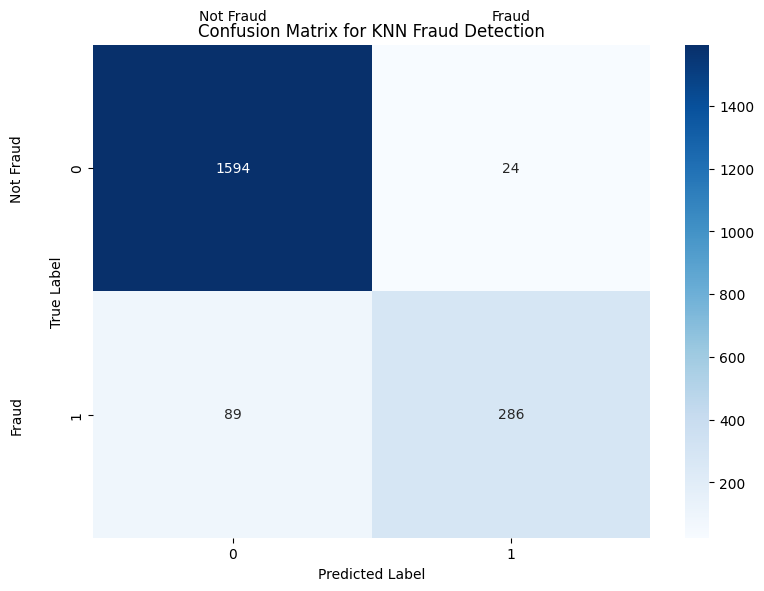


Detailed Classification Metrics:
------------------------------
True Negatives (Correct Non-Fraud): 1594
False Positives (Incorrect Fraud): 24
False Negatives (Missed Fraud): 89
True Positives (Correct Fraud): 286

Precision: 0.9226
Recall: 0.7627
F1 Score: 0.8350

Classification Report:
------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1618
           1       0.92      0.76      0.84       375

    accuracy                           0.94      1993
   macro avg       0.93      0.87      0.90      1993
weighted avg       0.94      0.94      0.94      1993



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# [Previous code remains the same until model evaluation]

# Create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and axis
    plt.figure(figsize=(8, 6))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Add labels and title
    plt.title('Confusion Matrix for KNN Fraud Detection')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add label text for each quadrant
    plt.text(-0.3, 0.5, 'Not Fraud', rotation=90, verticalalignment='center')
    plt.text(-0.3, 1.5, 'Fraud', rotation=90, verticalalignment='center')
    plt.text(0.5, -0.1, 'Not Fraud', horizontalalignment='center')
    plt.text(1.5, -0.1, 'Fraud', horizontalalignment='center')

    plt.tight_layout()
    plt.show()

    return cm

# Generate predictions
y_pred = knn.predict(X_test)

# Plot confusion matrix
cm = plot_confusion_matrix(y_test, y_pred)

# Calculate and print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nDetailed Classification Metrics:")
print("-" * 30)
print(f"True Negatives (Correct Non-Fraud): {tn}")
print(f"False Positives (Incorrect Fraud): {fp}")
print(f"False Negatives (Missed Fraud): {fn}")
print(f"True Positives (Correct Fraud): {tp}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Print classification report
print("\nClassification Report:")
print("-" * 30)
print(classification_report(y_test, y_pred))

In [ ]:
##try nn2

In [ ]:
# train.py - Model Training and Saving
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import joblib

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)

    attributes = [
        "Account_Age(months)",
        "Frequency_credential_change(per year)",
        "Return_to_Order",
        "VPN/Temp_Mail?",
        "Credit Score"
    ]

    if "VPN/Temp_Mail?" in data.columns:
        data["VPN/Temp_Mail?"] = data["VPN/Temp_Mail?"].map({"Yes": 1, "No": 0})
    if "Fraud/NOT" in data.columns:
        data["Fraud/NOT"] = data["Fraud/NOT"].map({"Yes": 1, "No": 0})

    data = data.dropna(subset=attributes + ["Fraud/NOT"])

    return data, attributes

def create_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

def train_and_save_model():
    # Load and preprocess data
    data, attributes = load_and_preprocess_data("Final_1.csv")  # Replace with your data path

    # Split features and target
    X = data[attributes]
    y = data["Fraud/NOT"]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save the scaler
    joblib.dump(scaler, 'scaler.save')

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Create and compile model
    model = create_model(X_train.shape[1])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Save the model with .keras extension
    model.save('fraud_detection_model.keras')

    return history, model, scaler

if __name__ == "__main__":
    history, model, scaler = train_and_save_model()

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8355 - loss: 0.5105 - val_accuracy: 0.9423 - val_loss: 0.2294
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9288 - loss: 0.2573 - val_accuracy: 0.9423 - val_loss: 0.2240
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9317 - loss: 0.2671 - val_accuracy: 0.9423 - val_loss: 0.2214
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9321 - loss: 0.2558 - val_accuracy: 0.9423 - val_loss: 0.2210
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9356 - loss: 0.2413 - val_accuracy: 0.9423 - val_loss: 0.2214
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9383 - loss: 0.2465 - val_accuracy: 0.9423 - val_loss: 0.2233
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9340 - loss: 0.2512 - val_accuracy: 0.9423 - val_loss: 0.2210
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.2363 - val_accuracy: 0

In [ ]:

from huggingface_hub import HfApi, create_repo, upload_file
import os
import sys
from pathlib import Path

def deploy_to_huggingface(
    model_path='fraud_detection_model.keras',
    scaler_path='scaler.save',
    repo_name='NiharMandahas/NN_EL',
    token='YOUR_HUGGING_FACE_TOKEN'
):
    """
    Deploy existing joblib files to Hugging Face

    Args:
        model_path (str): Path to the saved model file
        scaler_path (str): Path to the saved scaler file
        repo_name (str): Name of the Hugging Face repository (username/repo-name)
        token (str): Hugging Face API token

    Returns:
        str: URL of the deployed model repository
    """
    # Validate input files exist
    if not Path(model_path).exists():
        raise FileNotFoundError(f"Model file not found: {model_path}")
    if not Path(scaler_path).exists():
        raise FileNotFoundError(f"Scaler file not found: {scaler_path}")

    # Validate token
    if token == 'your_token_here':
        raise ValueError("Please provide a valid Hugging Face API token")

    # Initialize Hugging Face API
    try:
        api = HfApi()
        # Verify token works by getting user info
        user = api.whoami(token=token)
        print(f"Authenticated as: {user['name']}")
    except Exception as e:
        raise Exception(f"Failed to initialize Hugging Face API: {str(e)}")

    # Create repository (if it doesn't exist)
    try:
        create_repo(repo_name, token=token, exist_ok=True)
        print(f"Repository ready: {repo_name}")
    except Exception as e:
        raise Exception(f"Failed to create/verify repository: {str(e)}")

    # Create model card
    model_card = """---
tags:
- fraud-detection
- random-forest
- sklearn
library_name: sklearn
pipeline_tag: tabular-classification
---

# Random Forest Fraud Detection Model

This model uses Random Forest classification to detect potential fraud based on various account and transaction features.

## Model Description

- **Input Features:**
  - Account Age (months)
  - Frequency of credential changes (per year)
  - Return to Order ratio
  - VPN/Temp Mail usage (binary)
  - Credit Score

- **Output:** Binary classification (Fraud/Not Fraud)
- **Type:** Random Forest Classifier

## Usage

```python
import joblib
import numpy as np

# Load model and scaler
model = joblib.load('random_forest_model.joblib')
scaler = joblib.load('rf_scaler.joblib')

# Prepare input (example)
input_data = np.array([[25, 0.5, 0.4, 0, 800]])

# Scale input
scaled_input = scaler.transform(input_data)

# Get prediction
prediction = model.predict(scaled_input)
probability = model.predict_proba(scaled_input)
```

## Limitations and Bias

This model should be used as part of a larger fraud detection system and not in isolation.
"""

    # Save model card
    readme_path = Path('README.md')
    try:
        with open(readme_path, 'w') as f:
            f.write(model_card)
        print("Created README.md")
    except Exception as e:
        raise Exception(f"Failed to create README.md: {str(e)}")

    # Files to upload
    files_to_upload = {
        model_path: "fraud_detection_model.keras",
        scaler_path: "scaler.save",
        str(readme_path): 'README.md'
    }

    # Upload files
    for local_path, hf_path in files_to_upload.items():
        try:
            print(f"Uploading {local_path}...")
            api.upload_file(
                path_or_fileobj=local_path,
                path_in_repo=hf_path,
                repo_id=repo_name,
                token=token
            )
            print(f"Successfully uploaded {local_path} to {hf_path}")
        except Exception as e:
            raise Exception(f"Failed to upload {local_path}: {str(e)}")

    repo_url = f"https://huggingface.co/{repo_name}"
    print(f"\nDeployment complete! Your model is available at: {repo_url}")
    return repo_url





# Example usage
if __name__ == "__main__":
    try:
        url = deploy_to_huggingface(
            model_path= "fraud_detection_model.keras",
            scaler_path= "scaler.save",
            repo_name='NiharMandahas/NN_EL',
            token='YOUR_TOKEN_HERE'
        )
        print(f"Successfully deployed to: {url}")
    except Exception as e:
        print(f"Deployment failed: {str(e)}")
        sys.exit(1)

Authenticated as: NiharMandahas
Repository ready: NiharMandahas/NN_EL
Created README.md
Uploading fraud_detection_model.keras...
Successfully uploaded fraud_detection_model.keras to fraud_detection_model.keras
Uploading scaler.save...
Successfully uploaded scaler.save to scaler.save
Uploading README.md...
Successfully uploaded README.md to README.md

Deployment complete! Your model is available at: https://huggingface.co/NiharMandahas/NN_EL
Successfully deployed to: https://huggingface.co/NiharMandahas/NN_EL


In [ ]:
# train.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib

def create_model(input_dim):
    model = models.Sequential([
        # Modified input layer specification
        layers.InputLayer(input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_and_save_model():
    # Load and preprocess data
    data = pd.read_csv("Final_1.csv")  # Replace with your data path

    attributes = [
        "Account_Age(months)",
        "Frequency_credential_change(per year)",
        "Return_to_Order",
        "VPN/Temp_Mail?",
        "Credit Score"
    ]

    # Convert categorical variables
    if "VPN/Temp_Mail?" in data.columns:
        data["VPN/Temp_Mail?"] = data["VPN/Temp_Mail?"].map({"Yes": 1, "No": 0})
    if "Fraud/NOT" in data.columns:
        data["Fraud/NOT"] = data["Fraud/NOT"].map({"Yes": 1, "No": 0})

    # Drop rows with missing values
    data = data.dropna(subset=attributes + ["Fraud/NOT"])

    # Split features and target
    X = data[attributes]
    y = data["Fraud/NOT"]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save the scaler
    joblib.dump(scaler, 'scaler.save')

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Create and compile model
    model = create_model(X_train.shape[1])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Save the model in h5 format for better compatibility
    model.save('fraud_detection_model.h5')

    return history, model, scaler